# Splitting data into the train/validation/test dataset

It is important to split your full dataset into train/validation/test datasets, and reliably use the same datasets for your modeling tasks later.

Using different train/validation/test splits can dramatically affect your model performance (as seen here by the variance in $r^2$ scores for 30 models which have been trained on 30 different dataset splits) [1]:

[1]: C. Clement, S. K. Kauwe, T. D. Sparks, Benchmark AFLOW Data Sets for Machine Learning, figshare 2020, DOI: [10.6084/m9.figshare.11954742](https://dx.doi.org/10.6084/m9.figshare.11954742).

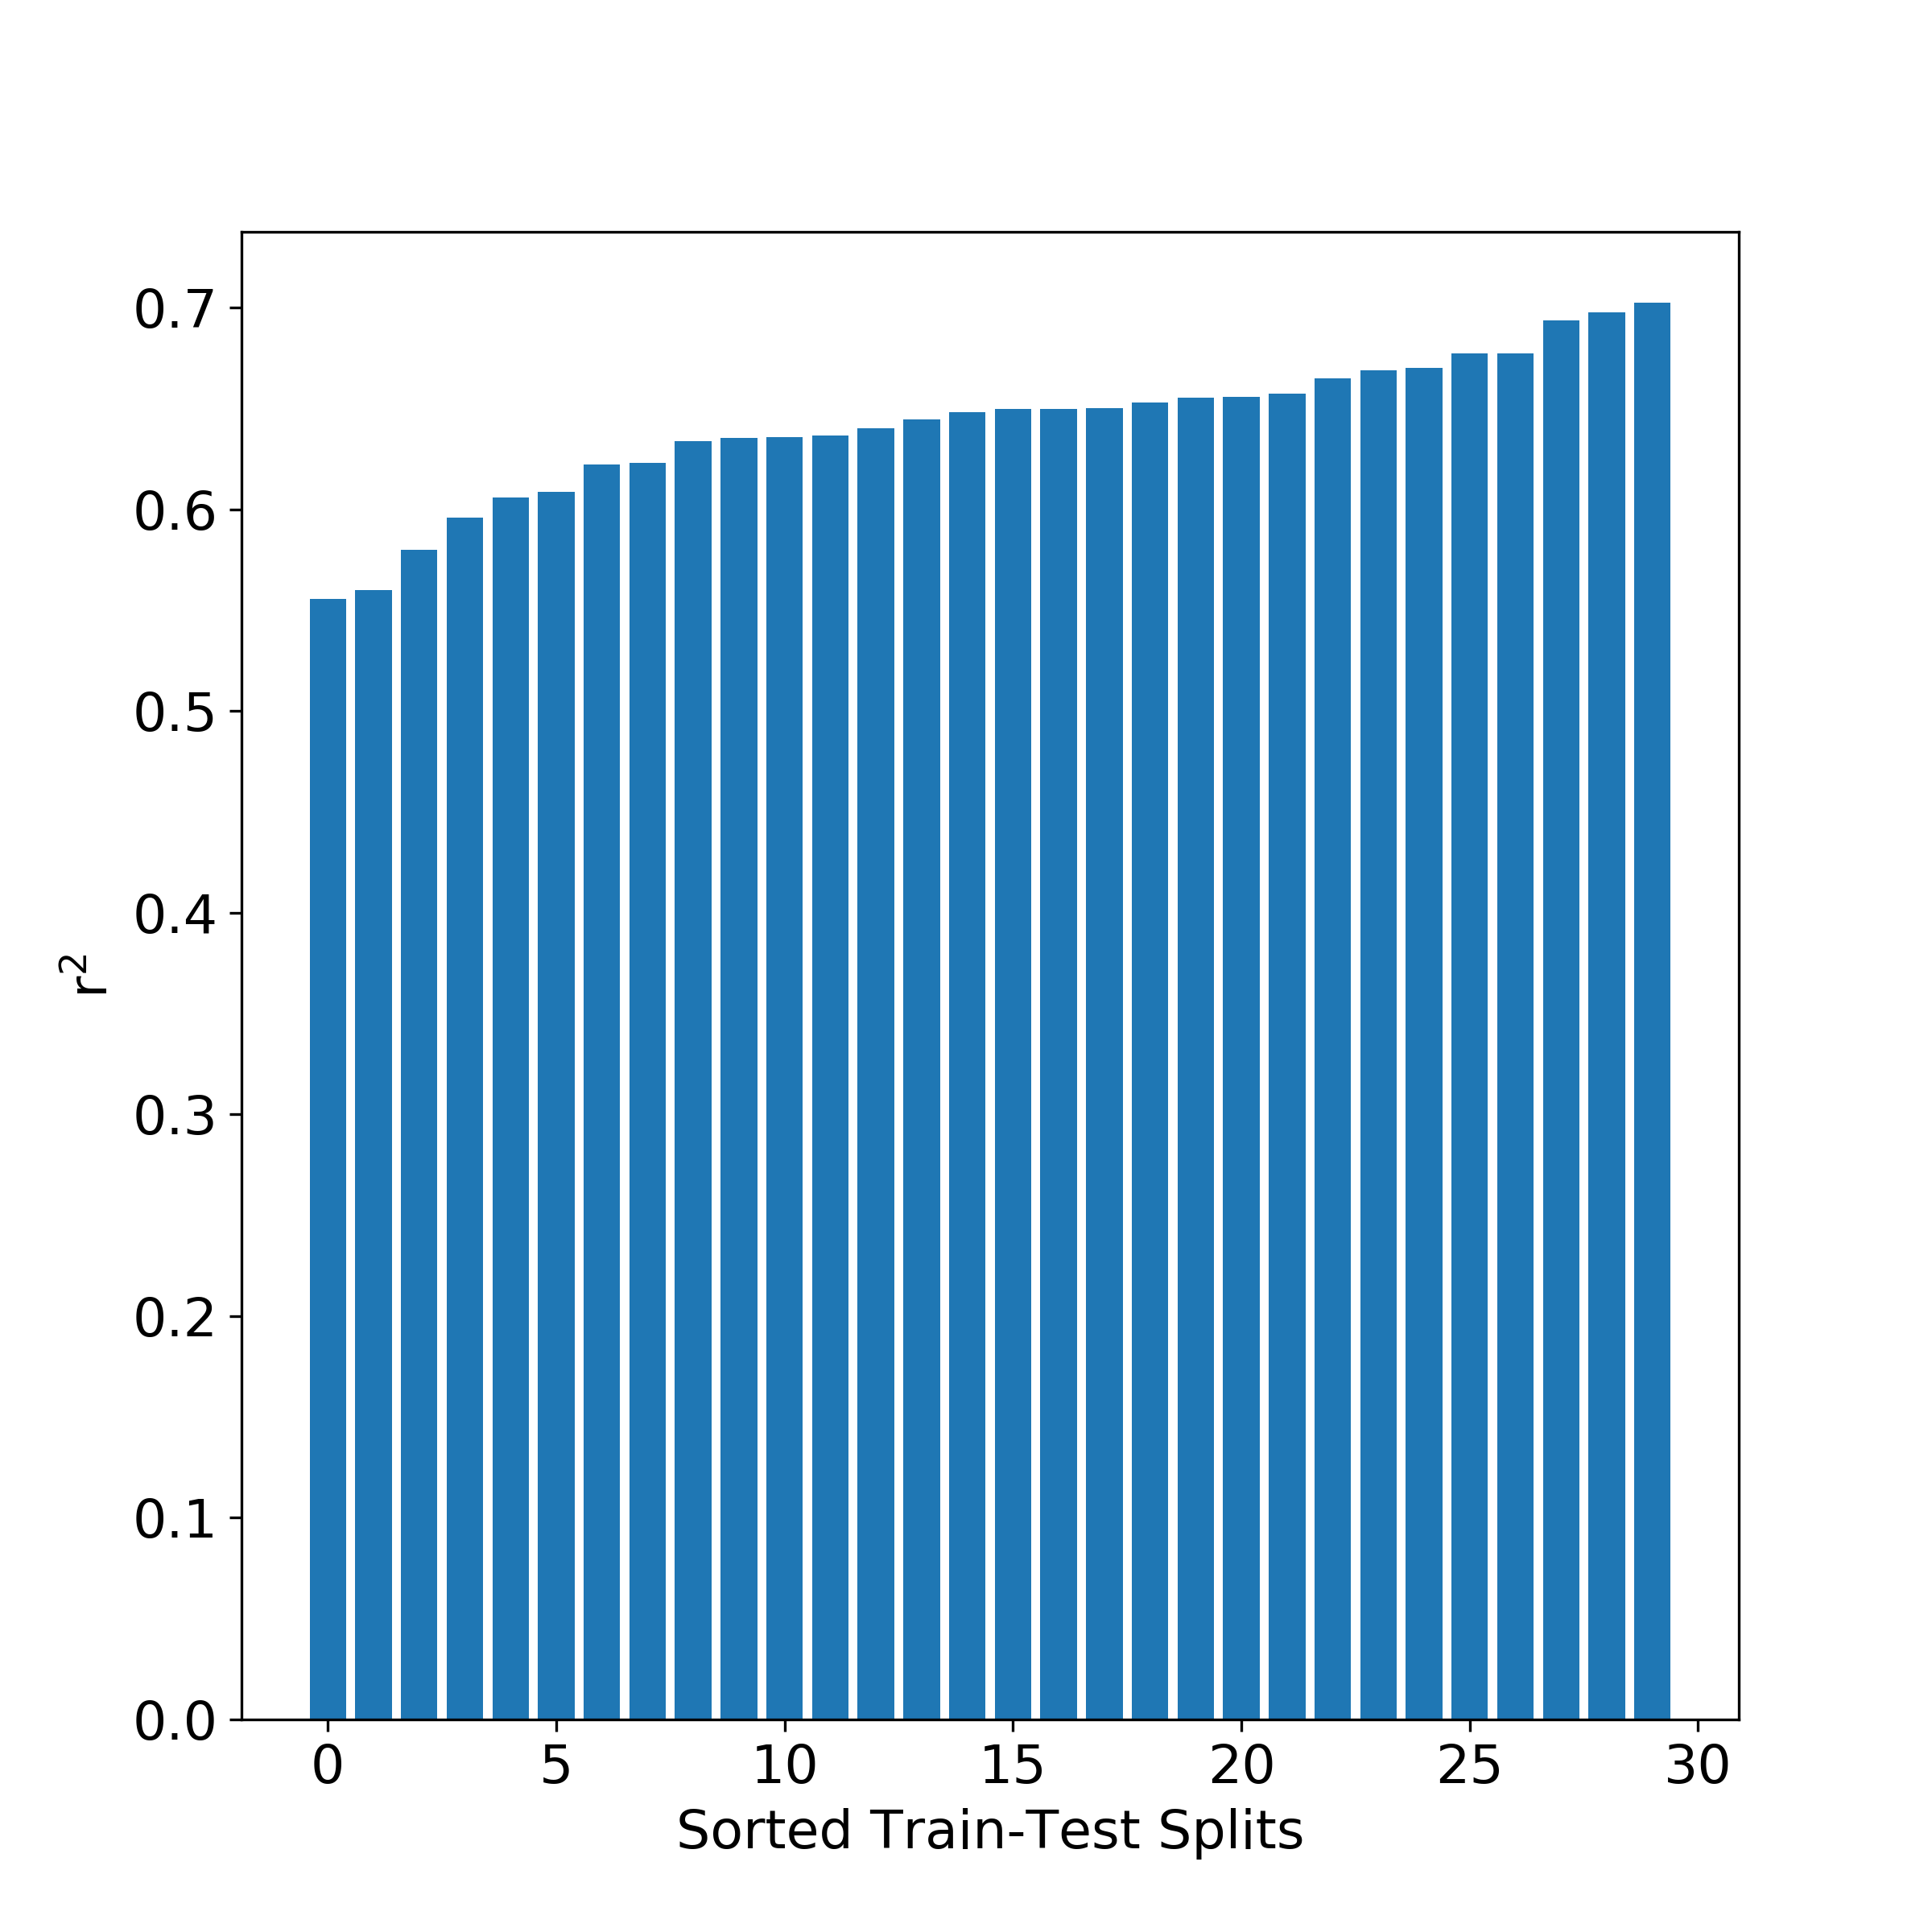

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets
                                                     #sklearn.x gives bunch of different models that can be used

#Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(seed = RNG_SEED)

## Load the pre-processed dataset

We will start with the processed dataset that we saved from the last notebook.

In [2]:
#getting access to the current working directory and the .csv storing the data we want to analyse
PATH = os.getcwd()
data_path = os.path.join(PATH, "../data_for_notebook_bestpractice/cp_data_cleaned_by_me.csv")

#creating the dataframe by reading the csv
df = pd.read_csv(data_path)

print("The shape of the DataFrame is:", df.shape)

#print(f"\nThe shape of the DataFrame is: {df.shape}") #just trying out the f strings here

The shape of the DataFrame is: (4564, 3)


In [3]:
#reading the first 10 rows
df.head(10)

,formula,T,Cp
0,B2O3,1400.0,134.306
1,B2O3,1300.0,131.294
2,B2O3,1200.0,128.072
3,B2O3,1100.0,124.516
4,B2O3,1000.0,120.625
5,B2O3,900.0,116.190
6,B2O3,800.0,111.169
7,B2O3,723.0,106.692
8,B2O3,700.0,105.228
9,B2O3,600.0,98.115


## Separate the DataFrame into your input variables ($X$) and target variables ($y$)

The $X$ will be used as the input data, and $y$ will be used as the prediction targets for your ML model.

If your target variables are discrete (such as `metal`/`non-metal` or types of crystal structures), then you will be performing a classification task.
In our case, since our target variables are continuous values (heat capacity), we are performing a regression task.

In [4]:
x = df[["formula", "T"]] #creates a subdataframe from the original, the inside ["","",....] picks which headers are in new df
y = df["Cp"]
#don't super understand how the above works, need to look at it again

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (4564, 2)
shape of y: (4564,)


## Splitting data (and a word of caution)
### Normally, we could simply split the data with a simple `sklearn` function

The scikit-learn `train_test_split` function randomly splits a dataset into train and test datasets.
Typically, you can use `train_test_split` to first split your data into "train" and "test" datasets, and then use the function again to split your "train" data into "train" and "validation" dataset splits.

As a rule of thumb, you can roughly aim for the following dataset proportions when splitting your data:

| | train split | validation split | test split |
| --- | --- | --- | --- |
| proportion<br> of original<br> dataset | 50% to 70% | 20% to 30% | 10% to 20% |

If you have copious amounts of data, it may suffice to train your models on just 50% of the data; that way, you have a larger amount of data samples to validate and to test with.
If you however have a smaller dataset and thus very few training samples for your models, you may wish to increase your proportion of training data during dataset splitting.

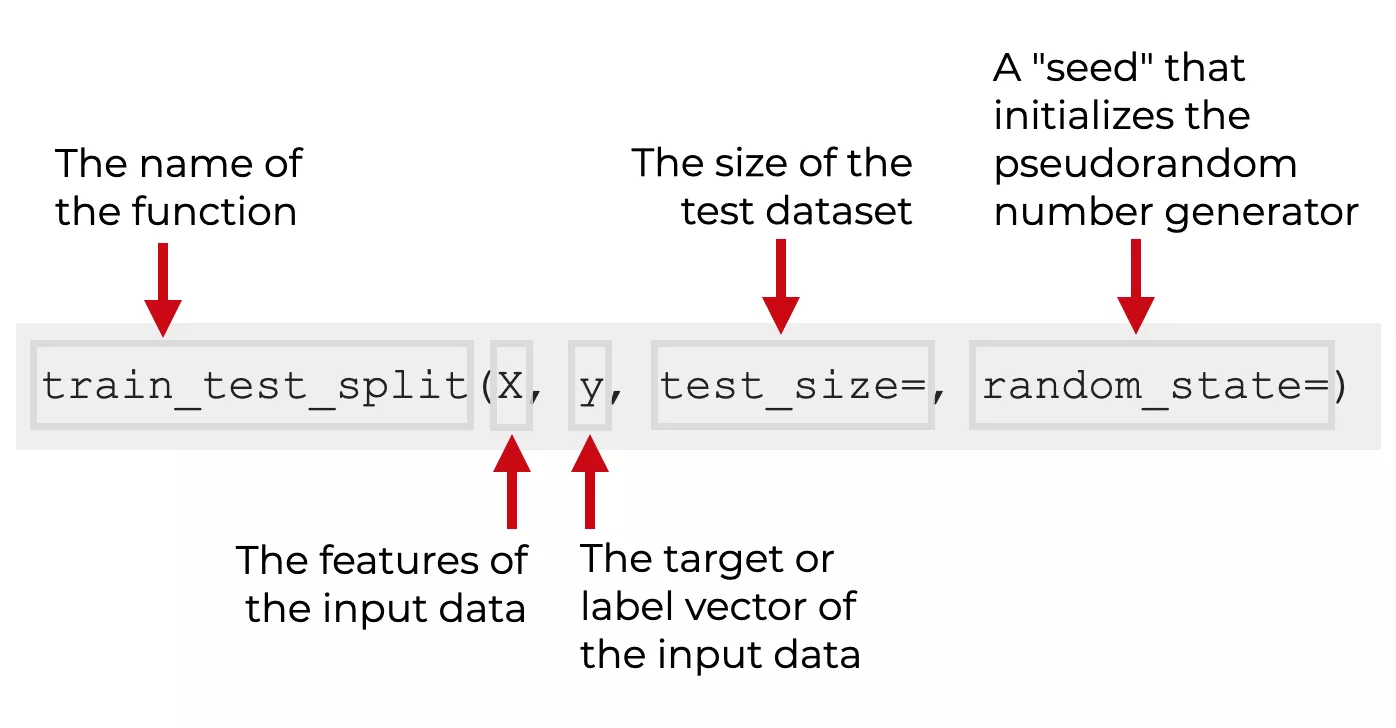

this picture explains the train_test_split() function

# need to understand the function used below better
# looking at what the function returns is probably a good start

In [5]:
#no clue how it decides which variable becomes which which set of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RNG_SEED)

#I think the varaibe declaration always goes variable 1 train/test, variable 2 train/test??? no clue though =(

print(x_train.shape)
print(x_test.shape)

(3651, 2)
(913, 2)


### But wait, what's wrong here?

We have to make sure that our dataset splits contain mutually exclusive formulae (e.g., all the data samples associated with "Al2O3" is *either* in the train, validation, or test dataset, but *not in multiple*)!

In [6]:
num_rows = len(x_train) #finding the number of rows in the dataframe
print("There are", num_rows, "rows in the x_train DataFrame")

num_unique_formulae = len(x_train["formula"].unique()) #length of column under heading formula, .unique() finds unique values
print("There are", num_unique_formulae, "unique chemical formulae in the test dataframe")
print("This means", num_rows - num_unique_formulae, "are repeated\n")


#.value_counts() return a series containing counts of unique values
unique_test_formulae = x_train["formula"].value_counts()
print("Unique formula and their counts in the test frame\n", unique_test_formulae)

There are 3651 rows in the x_train DataFrame
There are 244 unique chemical formulae in the test dataframe
This means 3407 are repeated

Unique formula and their counts in the test frame
 W1         40
N1Ti1      38
N1Zr1      33
B1Ti1      33
O2Zr1      30
           ..
Be1H2O2     4
N2O4        3
K1          2
Hg1O1       1
I4Ti1       1
Name: formula, Length: 244, dtype: int64


There are in total 3651 rows in the X_train DataFrame. But there are only 244 unique formulae!
In fact, you will see that the same formulae are often present in the X_train and X_test DataFrames!

That's not good, because now we have instances of the same chemical compound appearing in *both* the training and test data. Which means the model can cheat and in essence just memorize the training data, and during testing, look up the nearby values present in the training data!

So how do we mitigate this?

### Be aware of leaking data between datasets

We have to first group the data by chemical formula, then split the data according to the chemical formulae. That way, all data points associated with each formula are either in the training dataset or in the test dataset, *but not in both at the same time*.

## Splitting data, cautiously (manually)

First we get a list of all of the unique formulae in the dataset.

In [7]:
unique_formula = df["formula"].unique()
print("There are", len(unique_formula),"unique formulae:\n",
     unique_formula)

There are 244 unique formulae:
 ['B2O3' 'Be1I2' 'Be1F3Li1' 'Al1Cl4K1' 'Al2Be1O4' 'B2H4O4' 'B2Mg1' 'Be1F2'
 'B1H4Na1' 'Br2Ca1' 'Al1N1' 'Al1Cl6Na3' 'Ba1H2O2' 'Al1Br3' 'Br3Zr1'
 'Br2Ti1' 'B1Ti1' 'Be2O4Si1' 'Br2Pb1' 'Al1' 'Br2Hg2' 'B1H3O3' 'Br3Ti1'
 'C1Cu1N1' 'B1' 'Al1F6Na3' 'Ca1H2O2' 'B2Be3O6' 'Al1Cl4Na1' 'Al1Cl6K3'
 'C0.98Nb1' 'Br2Hg1' 'Al1Cl1O1' 'Cl1H4N1O4' 'Be1F4Li2' 'C1Mg1O3' 'Br1H4N1'
 'Ca1I2' 'Al1F6Li3' 'Br4Mo1' 'Ba1' 'Br4Ti1' 'Ba1Br2' 'Be1O4S1' 'Ba1F2'
 'Ba1I2' 'Cl2Fe1' 'C1K1N1' 'Be1H2O2' 'Cs1' 'Al1H4Li1' 'C1Be2' 'Cr1'
 'Cs2O4S1' 'Cl1Cu1' 'Cu1F2' 'Al2O3' 'B1N1' 'Co1O4S1' 'Cu1O1' 'Br1Na1'
 'Cr2O3' 'Cs1F1' 'Cr2N1' 'Cl1Li1' 'Fe0.877S1' 'Cl1Na1' 'F2Hg1' 'Fe1H2O2'
 'Cs1H1O1' 'Br3Mo1' 'Br2Sr1' 'Cl2Hg2' 'Fe1O1' 'Co1' 'Cl1Cs1' 'Cu1H2O2'
 'Al1Li1O2' 'Co1F2' 'Br2Fe1' 'Fe1I2' 'Ga1' 'Cl1Li1O4' 'Cl2Cu1' 'Fe0.947O1'
 'Be1Cl2' 'Cl1K1' 'F1Na1' 'H3O4P1' 'Fe3O4' 'H1Na1O1' 'Fe2O12S3' 'H1Na1'
 'Cl1Na1O4' 'B1F4K1' 'Cu1O4S1' 'H1Li1' 'F2H1K1' 'B1H4Li1' 'Hg1O1' 'Be3N2'
 'Fe1' 'I2Mo1' 'Cu1F1' 'Cr1N1' 'Fe1H

# need to understand the "f for f in allformulae if f not un valfromula"

In [8]:
#splitting everything manually

#Set a random seed to ensure reproducibility across runs
np.random.seed(seed=RNG_SEED)

# Store a list of all unique formulae
all_formulae = unique_formula.copy()

# Define the proportional size of the dataset split
val_size = 0.20
test_size = 0.10
train_size = 1 - val_size - test_size

# Calculate the number of samples in each dataset split
num_train_samples = round(train_size * len(unique_formula))
num_val_samples = round(val_size * len(unique_formula))
num_test_samples = round(test_size * len(unique_formula))

#Randomly choose the formulate for the validation dataset, and remove those from the unique formulae list
val_formulae = np.random.choice(all_formulae, num_val_samples, False) #picks random entries from the list, the np. expects a 1D array
#input is (arrayorsomething, size, replace)
#size is the output shape of random samples of numpy array
#replace set to false means that value cannot be chosen more than once

#removing the components from val_formulae from all_formulae
#newlist = [expression /for/ item /in/ iterable /if/ condition == True]
all_formulae = [f for f in all_formulae if f not in val_formulae] #don't super understand this I guess???

test_formulae = np.random.choice(all_formulae, num_test_samples, False)
all_formulae = [f for f in all_formulae if f not in test_formulae]

#eveything else is training data
train_formulae = all_formulae.copy()


print('Number of training formulae:', len(train_formulae))
print('Number of validation formulae:', len(val_formulae))
print('Number of testing formulae:', len(test_formulae))
print("number of formulae", len(unique_formula))

Number of training formulae: 171
Number of validation formulae: 49
Number of testing formulae: 24
number of formulae 244


In [9]:
#Spliting the original dataset into the train/validation/test datasets using the formulae lists above
df_train = df[df['formula'].isin(train_formulae)] #from colum formula adds to dataset if in train_formulae
df_val = df[df['formula'].isin(val_formulae)]
df_test = df[df['formula'].isin(test_formulae)]

print("Training DataFrame shape:", df_train.shape)
print("Validation DataFrame shape:", df_val.shape)
print("Testing DataFrame shape:", df_test.shape)

print("\n", df_train.head(), '\n') #default for .head() is 5
print(df_val.head(), '\n')
print(df_test.head(), '\n')

#same formula appears several times but at different temperatures in each set
#what is important is that though there are several B2O3 in train, there is none in val or test

Training DataFrame shape: (3214, 3)
Validation DataFrame shape: (980, 3)
Testing DataFrame shape: (370, 3)

   formula       T       Cp
0    B2O3  1400.0  134.306
1    B2O3  1300.0  131.294
2    B2O3  1200.0  128.072
3    B2O3  1100.0  124.516
4    B2O3  1000.0  120.625 

   formula       T      Cp
82   B2Mg1  1900.0  92.242
83   B2Mg1  1800.0  90.249
84   B2Mg1  1700.0  88.162
85   B2Mg1  1600.0  85.981
86   B2Mg1  1500.0  83.643 

     formula       T       Cp
192  Ba1H2O2  900.00  134.892
193  Ba1H2O2  800.00  130.834
194  Ba1H2O2  700.00  126.775
195  Ba1H2O2  681.15  126.022
196  Ba1H2O2  600.00  122.717 



To be sure that we really only have mutually exclusive formulae within each of the datasets (e.g., all the data samples associated with "Al2O3" is *either* in the train, validation, or test dataset, but *not in multiple*), we can do the following to check:

In [10]:
#Set is a collection which is unordered, unchangeable*, and unindexed. No duplicate members.
train_formulae = set(df_train['formula'].unique()) #turning each list into a unique set
val_formulae = set(df_val['formula'].unique())
test_formulae = set(df_test['formula'].unique())

common_formulae1 = train_formulae.intersection(test_formulae) #checking all possible intersections
common_formulae2 = train_formulae.intersection(val_formulae)
common_formulae3 = test_formulae.intersection(val_formulae)

print("Number of common formulae in intersection one:", len(common_formulae1), ".The common formulae are", common_formulae1)
print("Number of common formulae in intersection two:", len(common_formulae2), ".The common formulae are", common_formulae2)
print("Number of common formulae in intersection three:", len(common_formulae3), ".The common formulae are", common_formulae3)

Number of common formulae in intersection one: 0 .The common formulae are set()
Number of common formulae in intersection two: 0 .The common formulae are set()
Number of common formulae in intersection three: 0 .The common formulae are set()


## Save split datasets to csv

Finally, after splitting the dataset into train/validation/test dataset splits, you can save them to disc for you to use later.

By saving these dataset splits into files, you can then later reproducibly use these same exact splits during your subsequent model training and comparison steps.
Use the same datasets for all your models---that way, you can ensure a fair comparison.

Also, when you publish your results, you can include these dataset splits, so that others can use the exact datasets in their own studies.

In [11]:
# saving these splits into csv files
PATH = os.getcwd()

train_path = os.path.join(PATH, '../data_for_notebook_bestpractice/cp_train_byme.csv')
val_path = os.path.join(PATH, '../data_for_notebook_bestpractice/cp_val_byme.csv')
test_path = os.path.join(PATH, '../data_for_notebook_bestpractice/cp_test_byme.csv')

df_train.to_csv(train_path, index=False) #possibly just need False not index = False?
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Remember, keep the test dataset locked away and forget about it until you have finalized your model!
**Never look at the test dataset!!** 